# On-time arrival information for major U.S. Airlines
Each row represents one flight and contains 
information such as the origin, the destination, the scheduled departure time, and whether the flight arrived on time or late

Below we import the necessary data from Microsoft and create a pandas dataframe to handle the data

In [3]:
#Import the necessary data from Microsoft
!curl https://topcs.blob.core.windows.net/public/FlightData.csv -o flightdata.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1552k  100 1552k    0     0  1422k      0  0:00:01  0:00:01 --:--:-- 1423k


In [4]:
import pandas as pd

df = pd.read_csv('flightdata.csv')
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [5]:
#let's grab the shape of the dataset
df.shape

(11231, 26)

Let's eliminate extraneous columns and replace missing values in the remaining columns. This dataset is far from clean, and there are some variables that could cause Multicollinearity.

In [6]:
#Are there any null values?
print(df.isnull().values.any())

#How about missing?
print(df.isnull().sum())

True
YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64


In [7]:
#First let's drop the 26th column that is unnamed. That's an error caused by the csv import
df = df.drop('Unnamed: 25', axis=1)
df.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

## We're trying to to have some type of predictability for Arrival times
With this in mind, we should eliminate columns that would most likely have no bearing on Arrival time. Such as the tail_num variable that represents the aircrafts Tail Number

In [8]:
df = df[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]]
df.isnull().sum()


# MONTH	Month that the flight took place (1-12)
# DAY_OF_MONTH	Day of the month that the flight took place (1-31)
# DAY_OF_WEEK	Day of the week that the flight took place (1=Monday, 2=Tuesday, etc.)
# ORIGIN	Origin airport code (ATL, DFW, SEA, etc.)
# DEST	Destination airport code (ATL, DFW, SEA, etc.)
# CRS_DEP_TIME	Scheduled departure time
# ARR_DEL15	0=Arrived less than 15 minutes late, 1=Arrived 15 minutes or more late

MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
ARR_DEL15       188
dtype: int64

In [9]:
#Let's go ahead and look at the head of the missing data
df[df.isnull().values.any(axis=1)].head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,NaN
179,1,10,7,MSP,DTW,1348,NaN
184,1,10,7,MSP,DTW,625,NaN
210,1,10,7,DTW,MSP,1200,NaN
478,1,22,5,SEA,JFK,2305,NaN


The reason these rows are missing ARR_DEL15 values is that they all correspond to flights that were canceled or diverted. You could call dropna on the DataFrame to remove these rows. But since a flight that is canceled or diverted to another airport could be considered "late," let's use the fillna method to replace the missing values with 1s.

In [10]:
df = df.fillna({'ARR_DEL15': 1})
df.iloc[177:185]

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,1.0
178,1,9,6,DTW,JFK,1527,0.0
179,1,10,7,MSP,DTW,1348,1.0
180,1,10,7,DTW,MSP,1540,0.0
181,1,10,7,JFK,ATL,1325,0.0
182,1,10,7,JFK,ATL,610,0.0
183,1,10,7,JFK,SEA,1615,0.0
184,1,10,7,MSP,DTW,625,1.0


I also want to focus on the un-binned Departure times. CRS_DEP_TIME. If we were to bring them down to 10's, it may help us as we don't necessarilly need that granularity


In [11]:
import math

for i, row in df.iterrows():
    df.loc[i, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,19,0.0
1,1,1,5,DTW,MSP,13,0.0
2,1,1,5,ATL,SEA,9,0.0
3,1,1,5,SEA,MSP,8,0.0
4,1,1,5,SEA,DTW,23,0.0


Now we can see that our times are converted to the hours. It doesn't necessarilly matter if a plain is 20 minutes late, however, a plane that is 4 hrs late matters.

In [12]:
df = pd.get_dummies(df, columns=['ORIGIN', 'DEST'])
df.head()

#generate indicator columns from the ORIGIN and DEST columns, while dropping the ORIGIN and DEST columns themselves

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,19,0.0,1,0,0,0,0,0,0,0,0,1
1,1,1,5,13,0.0,0,1,0,0,0,0,0,0,1,0
2,1,1,5,9,0.0,1,0,0,0,0,0,0,0,0,1
3,1,1,5,8,0.0,0,0,0,0,1,0,0,0,1,0
4,1,1,5,23,0.0,0,0,0,0,1,0,1,0,0,0


In [13]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop('ARR_DEL15', axis=1), df['ARR_DEL15'], test_size=0.2, random_state=42)

# The first statement imports scikit-learn's train_test_split helper function. 
# The second line uses the function to split the DataFrame into a training set containing 80% of the original data,
# and a test set containing the remaining 20%. The random_state parameter seeds the random-number generator used to do the splitting, 
# while the first and second parameters are DataFrames containing the feature columns and the label column.

train_x.shape

(8984, 14)

In [14]:
test_x.shape

(2247, 14)

We're going to build a Binary Classification Model

That is one where it predicts whether a flight will arrive on-time or late ("binary" because there are only two possible outputs).

We'll use SKLearn

In [15]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state = 10, n_estimators = 100) #n_estimators = 100 default for the newest version
model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

# Training the Model

In [16]:
predicted = model.predict(test_x)
model.score(test_x, test_y)

0.8642634623943035

The mean accuracy is 86%, which seems good on the surface. However, mean accuracy isn't always a reliable indicator of the accuracy of a classification model. Let's dig a little deeper and determine how accurate the model really is — that is, how adept it is at determining whether a flight will arrive on time.

One of the best overall measures for a binary classification model is Area Under Receiver Operating Characteristic Curve (sometimes referred to as "ROC AUC"), which essentially quantifies how often the model will make a correct prediction regardless of the outcome

In [17]:
from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)

ROC AUC takes this into account and provides a more accurate indication of how likely it is that a prediction of on-time or late will be correct.

In [18]:
roc_auc_score(test_y, probabilities[:, 1])

0.7036975831096701

You can learn more about the model's behavior by generating a confusion matrix, also known as an error matrix. The confusion matrix quantifies the number of times each answer was classified correctly or incorrectly. Specifically, it quantifies the number of false positives, false negatives, true positives, and true negatives

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[1906,   30],
       [ 275,   36]])

The first column shows how many delayed flights were incorrectly predicted to be on time. The second column shows how many flights were correctly predicted to be delayed. Clearly, the model isn't nearly as adept at predicting that a flight will be delayed as it is at predicting that a flight will arrive on time. What you want in a confusion matrix is large numbers in the upper-left and lower-right corners, and small numbers (preferably zeros) in the upper-right and lower-left corners.

Scikit-learn contains a handy method named precision_score for computing precision. To quantify the precision of your model, execute the following statements:

In [20]:
from sklearn.metrics import precision_score

train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions)

1.0

In [21]:
from sklearn.metrics import recall_score

recall_score(train_y, train_predictions)

0.9992012779552716

# Visualizing the Output

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Text(0, 0.5, 'True Positive Rate')

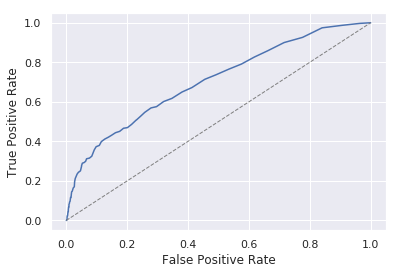

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

The dotted line in the middle of the graph represents a 50-50 chance of obtaining a correct answer. The blue curve represents the accuracy of the model.

In [24]:
#Now let's bring in a function that predicts the flight arrival times:
def predict_delay(departure_date_time, origin, destination):
    from datetime import datetime

    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [{'MONTH': month,
              'DAY': day,
              'DAY_OF_WEEK': day_of_week,
              'CRS_DEP_TIME': hour,
              'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
              'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
              'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
              'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
              'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
              'DEST_ATL': 1 if destination == 'ATL' else 0,
              'DEST_DTW': 1 if destination == 'DTW' else 0,
              'DEST_JFK': 1 if destination == 'JFK' else 0,
              'DEST_MSP': 1 if destination == 'MSP' else 0,
              'DEST_SEA': 1 if destination == 'SEA' else 0 }]

    return model.predict_proba(pd.DataFrame(input))[0][0]

This function takes as input a date and time, an origin airport code, and a destination airport code, and returns a value between 0.0 and 1.0 indicating the probability that the flight will arrive at its destination on time. It uses the machine-learning model and it passes a DataFrame containing the input values to predict_proba. The structure of the DataFrame exactly matches the structure of the DataFrame we used earlier

In [26]:
#Compute the probability that a flight from New York to Atlanta on the evening of October 1 will arrive on time
predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL')

0.67

In [27]:
predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL')

0.85

In [28]:
predict_delay('2/10/2018 10:00:00', 'ATL', 'SEA')

0.9

(0.0, 1.0)

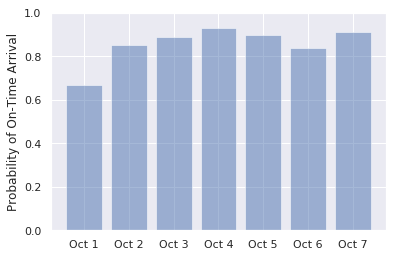

In [29]:
#Now lets plot it over a few days:
import numpy as np

labels = ('Oct1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('3/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('4/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('5/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('6/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('7/10/2018 21:45:00', 'JFK', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))